In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time

In [2]:
@dataclass
class GalaParams:
    d: float       # hole diameter [m]
    rmax: float    # maximum radial extent of the simulation domain [m]
    l1: float      # z-position of anode (potential Va) [m]
    l2: float      # z-position of gate (potential Vg) [m]
    l3: float      # z-position of top electrode (potential V0) [m]
    Va: float      # anode potential [V]
    Vg: float      # gate potential [V]
    V0: float      # top electrode potential [V]


In [3]:
# Helper function to map (i, j) indices (0-indexed) into a single linear index.
def idx(i, j, Nr):
    return j * Nr + i


In [4]:
def assemble_matrix(params: GalaParams, Nr: int, Nz: int):
    # Create uniform grids in r and z.
    r = np.linspace(0, params.rmax, Nr)
    z = np.linspace(0, params.l3, Nz)
    dr = r[1] - r[0]
    dz = z[1] - z[0]
    Ntot = Nr * Nz

    rows = []
    cols = []
    data = []
    b_vec = np.zeros(Ntot)

    # Identify indices for boundaries:
    j_z0 = np.argmin(np.abs(z - 0.0))       # bottom (z=0)
    j_zl1 = np.argmin(np.abs(z - params.l1))  # anode
    j_zl2 = np.argmin(np.abs(z - params.l2))  # gate
    j_zl3 = np.argmin(np.abs(z - params.l3))  # top

    for j in range(Nz):
        for i in range(Nr):
            index_ij = idx(i, j, Nr)
            r_val = r[i]

            # --- Boundary Conditions in z ---
            if j == j_z0:
                # Bottom boundary: φ = 0.
                rows.append(index_ij)
                cols.append(index_ij)
                data.append(1.0)
                b_vec[index_ij] = 0.0
            elif j == j_zl3:
                # Top boundary: φ = V0.
                rows.append(index_ij)
                cols.append(index_ij)
                data.append(1.0)
                b_vec[index_ij] = params.V0
            elif (j == j_zl1) and (r_val <= params.d / 2):
                # At z=l1 (anode): φ = Va for r <= d/2.
                rows.append(index_ij)
                cols.append(index_ij)
                data.append(1.0)
                b_vec[index_ij] = params.Va
            elif (j == j_zl2) and (r_val <= params.d / 2):
                # At z=l2 (gate): φ = Vg for r <= d/2.
                rows.append(index_ij)
                cols.append(index_ij)
                data.append(1.0)
                b_vec[index_ij] = params.Vg
            else:
                # --- Interior nodes (or nodes not constrained by electrode data) ---
                # Discretize the z second derivative using central differences:
                coeff_z = 1 / dz**2
                rows.append(index_ij)
                cols.append(idx(i, j+1, Nr))
                data.append(coeff_z)
                rows.append(index_ij)
                cols.append(idx(i, j-1, Nr))
                data.append(coeff_z)
                rows.append(index_ij)
                cols.append(index_ij)
                data.append(-2 * coeff_z)

                # Discretize the r-part:
                if i == 0:
                    # At r = 0, enforce symmetry: φ(0,j) = φ(1,j)
                    rows.append(index_ij)
                    cols.append(idx(0, j, Nr))
                    data.append(1.0)
                    rows.append(index_ij)
                    cols.append(idx(1, j, Nr))
                    data.append(-1.0)
                elif i == Nr - 1:
                    # At r = rmax, impose a Neumann condition: φ(Nr-1,j) = φ(Nr-2,j)
                    rows.append(index_ij)
                    cols.append(idx(Nr-1, j, Nr))
                    data.append(1.0)
                    rows.append(index_ij)
                    cols.append(idx(Nr-2, j, Nr))
                    data.append(-1.0)
                else:
                    # For interior r points:
                    # Second derivative in r:
                    rows.append(index_ij)
                    cols.append(idx(i+1, j, Nr))
                    data.append(1 / dr**2)
                    rows.append(index_ij)
                    cols.append(idx(i-1, j, Nr))
                    data.append(1 / dr**2)
                    rows.append(index_ij)
                    cols.append(index_ij)
                    data.append(-2 / dr**2)
                    # First derivative term (phi_r) approximated by central difference divided by r:
                    rows.append(index_ij)
                    cols.append(idx(i+1, j, Nr))
                    data.append(1 / (2 * dr * r_val))
                    rows.append(index_ij)
                    cols.append(idx(i-1, j, Nr))
                    data.append(-1 / (2 * dr * r_val))
    # Assemble sparse matrix A from contributions.
    A = sp.coo_matrix((data, (rows, cols)), shape=(Ntot, Ntot)).tocsr()
    return A, b_vec, r, z

In [11]:
def solve_laplace_gala(params: GalaParams, Nr: int, Nz: int):
    A, b, r_grid, z_grid = assemble_matrix(params,Nr, Nz)
    
    # Solve the linear system A * phi = b.
    phi_vec = spla.spsolve(A, b)
    phi_mat = phi_vec.reshape((Nr, Nz))
    return r_grid, z_grid, phi_mat
    

## Analysis

In [33]:
# --- GALA Problem Parameters ---
d = 2.5      # hole diameter [m]
rmax = 5.0    # maximum radial coordinate [m] (choose rmax >= d)
l1 = 5.0    # z-position of anode [m] (potential Va)
l2 = 10.0    # z-position of gate [m] (potential Vg)
l3 = 12.0    # z-position of top electrode [m] (potential V0)
Va = 100.0    # anode potential [V]
Vg = -120E+3 # gate potential [V]
V0 = -125E+3  # top electrode potential [V]

# --- Grid Setup ---
Nr = 201  # number of grid points in r
Nz = 201 # number of grid points in z
params = GalaParams(d, rmax, l1 , l2, l3, Va, Vg, V0)

In [19]:
# For inspection, print the Frobenius norm of the matrix.


Frobenius norm of Python matrix: =1.01e+06


In [34]:
start = time.time()
r, z, phi_mat = solve_laplace_gala(params, Nr, Nz)
elapsed = time.time() - start
print(f"Nr = {Nr}, Nz = {Nz}: Elapsed time (Python):", elapsed, "seconds")

Nr = 201, Nz = 201: Elapsed time (Python): 0.3480558395385742 seconds


In [30]:
np.linalg.norm(phi_mat, 'fro') 

7645565.552838059

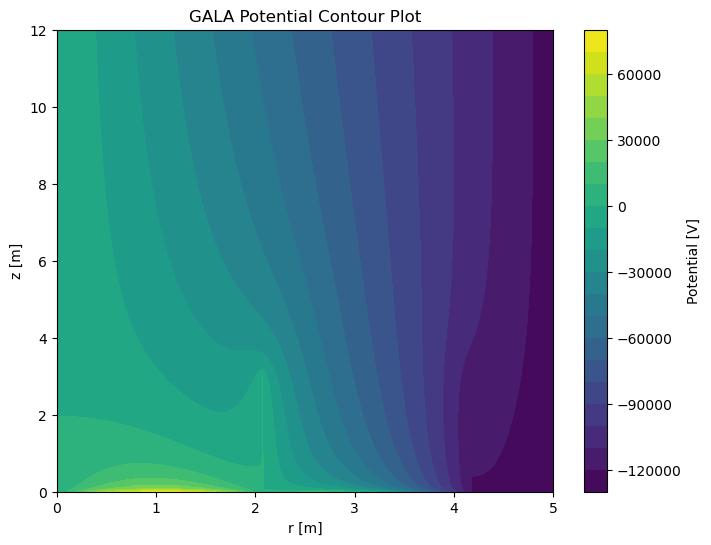

In [35]:
# --- Plot the Potential ---
# Create meshgrid for plotting (r is horizontal, z vertical)
R, Z = np.meshgrid(r, z, indexing='ij')

plt.figure(figsize=(8,6))
cp = plt.contourf(R, Z, phi_mat, levels=20, cmap='viridis')
plt.colorbar(cp, label='Potential [V]')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.title('GALA Potential Contour Plot')
plt.show()

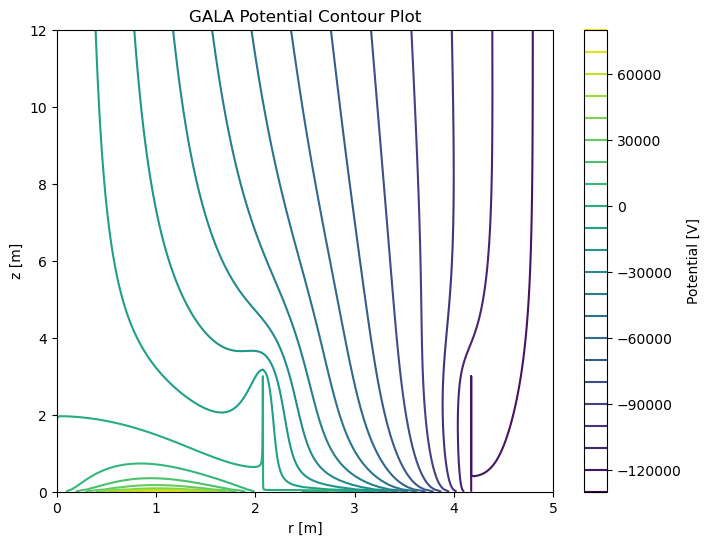

In [36]:
plt.figure(figsize=(8,6))
cp = plt.contour(R, Z, phi_mat, levels=20, cmap='viridis')
plt.colorbar(cp, label='Potential [V]')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.title('GALA Potential Contour Plot')
plt.show()

In [37]:
def compute_E_field(phi_mat: np.ndarray, r: np.ndarray, z: np.ndarray):
    """
    Computes the electric field components (E_r and E_z) from the potential field phi_mat
    using finite difference approximations.
    
    Parameters:
      phi_mat : 2D numpy array of shape (Nr, Nz)
                The computed potential values on the (r, z) grid.
      r : 1D numpy array of length Nr
          The radial grid.
      z : 1D numpy array of length Nz
          The vertical grid.
          
    Returns:
      (E_r, E_z) : tuple of 2D numpy arrays, each of shape (Nr, Nz), representing:
          E_r = -∂φ/∂r  (radial component)
          E_z = -∂φ/∂z  (vertical component)
    """
    Nr, Nz = phi_mat.shape
    dr = r[1] - r[0]
    dz = z[1] - z[0]
    
    E_r = np.zeros((Nr, Nz))
    E_z = np.zeros((Nr, Nz))
    
    for j in range(Nz):
        for i in range(Nr):
            # Compute the radial derivative d(phi)/dr:
            if i == 0:
                # Forward difference at r = 0.
                E_r[i, j] = -(phi_mat[i+1, j] - phi_mat[i, j]) / dr
            elif i == Nr - 1:
                # Backward difference at r = rmax.
                E_r[i, j] = -(phi_mat[i, j] - phi_mat[i-1, j]) / dr
            else:
                # Central difference for interior points.
                E_r[i, j] = -(phi_mat[i+1, j] - phi_mat[i-1, j]) / (2 * dr)
                
            # Compute the vertical derivative d(phi)/dz:
            if j == 0:
                # Forward difference at z = 0.
                E_z[i, j] = -(phi_mat[i, j+1] - phi_mat[i, j]) / dz
            elif j == Nz - 1:
                # Backward difference at z = l3.
                E_z[i, j] = -(phi_mat[i, j] - phi_mat[i, j-1]) / dz
            else:
                # Central difference for interior points.
                E_z[i, j] = -(phi_mat[i, j+1] - phi_mat[i, j-1]) / (2 * dz)
    
    return E_r, E_z



In [38]:
# Example usage:
if __name__ == "__main__":
    

    E_r, E_z = compute_E_field(phi_mat, r, z)
    
    # Optionally, print or plot the computed electric field.
    print("E_r shape:", E_r.shape)
    print("E_z shape:", E_z.shape)

E_r shape: (201, 201)
E_z shape: (201, 201)


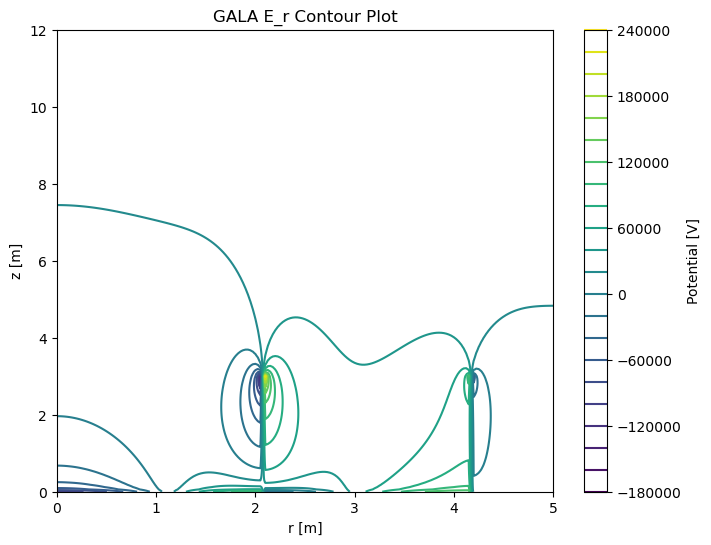

In [41]:
plt.figure(figsize=(8,6))
cp = plt.contour(R, Z, E_r, levels=20, cmap='viridis')
plt.colorbar(cp, label='Potential [V]')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.title('GALA E_r Contour Plot')
plt.show()

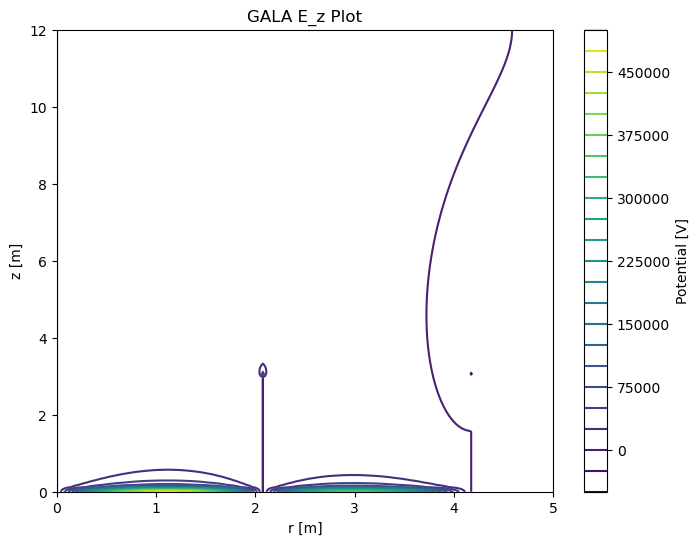

In [42]:
plt.figure(figsize=(8,6))
cp = plt.contour(R, Z, E_z, levels=20, cmap='viridis')
plt.colorbar(cp, label='Potential [V]')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.title('GALA E_z Plot')
plt.show()

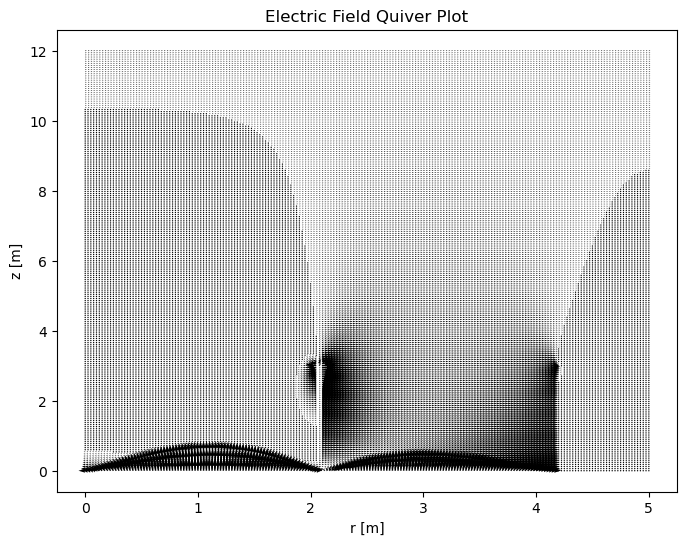

In [50]:

# Create a quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(R, Z, E_r, E_z, scale=1e+7)  # scale parameter may be adjusted for clarity
plt.xlabel("r [m]")
plt.ylabel("z [m]")
plt.title("Electric Field Quiver Plot")
plt.show()

## Tests

In [25]:
A, b, r_grid, z_grid = assemble_matrix(params,211, 211)
denseA  = A.toarray()
fro_norm = np.linalg.norm(denseA, 'fro')
print(f"Frobenius norm of Python matrix: ={fro_norm:.2e}")